In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from google.colab import files

# Upload files using Google Colab file upload
uploaded = files.upload()




Saving InjuryRecord.csv to InjuryRecord (1).csv


In [3]:
from google.colab import files

uploaded = files.upload()

Saving PlayList.csv to PlayList.csv


In [4]:

# Load the datasets after uploading
injury_file_path = 'InjuryRecord.csv'  # Use the name of your uploaded InjuryRecord CSV file
playlist_file_path = 'PlayList.csv'    # Use the name of your uploaded PlayList CSV file

injury_data = pd.read_csv(injury_file_path)
playlist_data = pd.read_csv(playlist_file_path)

# Merge the datasets on PlayerKey to ensure we have the same players
merged_data = pd.merge(injury_data, playlist_data, on='PlayerKey', how='inner')

# Determine who is injured and who isn't based on the presence of the BodyPart column
merged_data['IsInjured'] = merged_data['BodyPart'].notnull()

# Filter the data to only include injured players (for multi-class classification)
injured_data = merged_data[merged_data['IsInjured'] == True]



In [5]:
# Convert 'Surface' categorical variable to numeric values
merged_data['Surface'] = merged_data['Surface'].astype('category').cat.codes

# Define features for multi-class classification (Injury Type Prediction)
X_injured = merged_data[merged_data['IsInjured'] == True][['Surface', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42', 'Temperature']]
y_injured = merged_data[merged_data['IsInjured'] == True]['BodyPart']

# Split the data into training and testing sets for multi-class classification (Injury Type Prediction)
X_train_injured, X_test_injured, y_train_injured, y_test_injured = train_test_split(X_injured, y_injured, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier for multi-class classification
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the model
rf_classifier.fit(X_train_injured, y_train_injured)


RandomForestClassifier(random_state=42)

Classification Report:
               precision    recall  f1-score   support

       Ankle       0.66      0.72      0.69      8601
        Foot       0.70      0.82      0.75      1327
        Heel       1.00      0.05      0.09       103
        Knee       0.65      0.66      0.66      7712
        Toes       0.59      0.19      0.29      1474

    accuracy                           0.66     19217
   macro avg       0.72      0.49      0.50     19217
weighted avg       0.66      0.66      0.65     19217



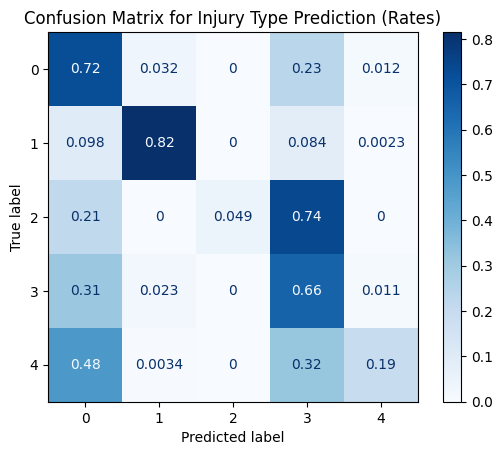

In [9]:
# Predict the injury type (BodyPart) for the test set
y_pred_injured = rf_classifier.predict(X_test_injured)

# Evaluate the model performance
print("Classification Report:\n", classification_report(y_test_injured, y_pred_injured))

# Confusion Matrix - Rates
cm_injury_type = confusion_matrix(y_test_injured, y_pred_injured)
cm_injury_type_rate = cm_injury_type.astype('float') / cm_injury_type.sum(axis=1)[:, np.newaxis]  # Convert to rates

# Plot confusion matrix with rates
disp_injury_type = ConfusionMatrixDisplay(confusion_matrix=cm_injury_type_rate)
disp_injury_type.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Injury Type Prediction (Rates)')
plt.show()

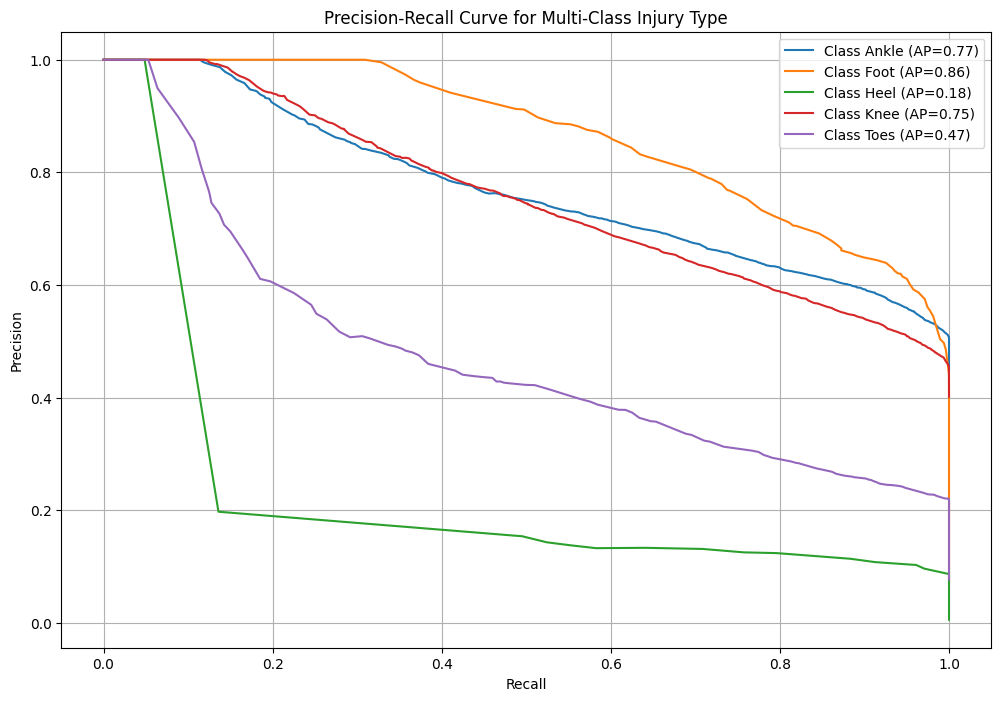

In [13]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Prepare the data for precision-recall curve
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test_injured)
y_pred_prob_bin = rf_classifier.predict_proba(X_test_injured)

# Plot Precision-Recall curve for each class
plt.figure(figsize=(12, 8))
for i in range(y_test_bin.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob_bin[:, i])
    plt.plot(recall, precision, label=f'Class {lb.classes_[i]} (AP={average_precision_score(y_test_bin[:, i], y_pred_prob_bin[:, i]):.2f})')

# Plot overall Precision-Recall curve
plt.title('Precision-Recall Curve for Multi-Class Injury Type')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()


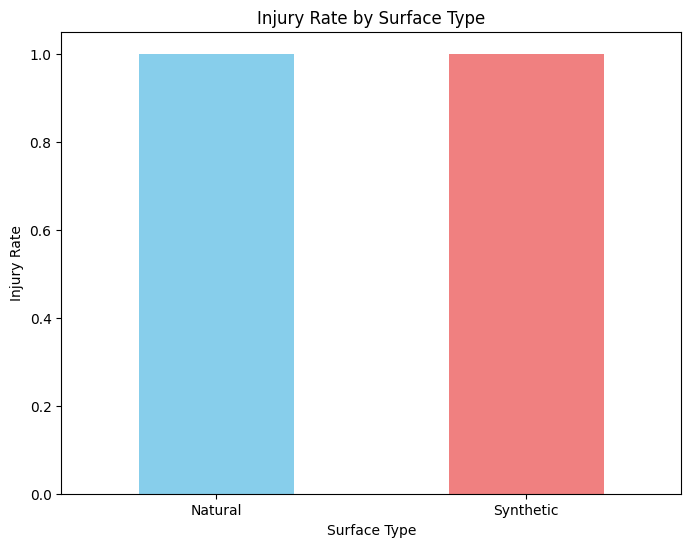

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mapping Surface Type to descriptive labels
surface_type_mapping = {0: 'Synthetic', 1: 'Natural'}
merged_data['Surface'] = merged_data['Surface'].map(surface_type_mapping)

# Group by the Surface and calculate the injury rate
surface_injury_rate = merged_data.groupby('Surface')['IsInjured'].mean()

# Plot the injury rate by surface type with descriptive labels
surface_injury_rate.plot(kind='bar', figsize=(8, 6), color=['skyblue', 'lightcoral'])
plt.title('Injury Rate by Surface Type')
plt.xlabel('Surface Type')
plt.ylabel('Injury Rate')
plt.xticks(rotation=0)  # Ensure the labels are not rotated
plt.show()

In [16]:
# Count injury and non-injury cases for each surface type
surface_injury_counts = merged_data.groupby('Surface')['IsInjured'].value_counts(normalize=True).unstack(fill_value=0)

# Show the counts
print(surface_injury_counts)

IsInjured  True
Surface        
Natural     1.0
Synthetic   1.0
